
# Spot resources Analytics

Here we perform some initial process and analysis on the dataset.

---




With static dataset, e.g. load the grabbed data.

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [13]:
# parse the data file and extra the results
filename = '../1g-data'

df = pd.read_csv(filename, sep="\t", header = None)
df.columns = ["info", "SpotPrice", "TimeStamp", "InstanceType", "OS type", "AvailabilityZone"]
df['TimeStamp'] =pd.to_datetime(df.TimeStamp)

df.index = df.TimeStamp
df = df.drop('info', 1).drop(['OS type'],axis=1)
df = df.drop(['TimeStamp'],axis=1).sort_index()
 

df.head(15)
print (df['InstanceType'].unique())
print (df['AvailabilityZone'].unique())


['c3.8xlarge' 'g2.2xlarge' 'c3.4xlarge' 'm3.medium' 'c3.xlarge' 't1.micro'
 'm1.small' 'm3.large' 'm3.2xlarge' 'c3.large' 'm3.xlarge' 'c3.2xlarge'
 'r3.2xlarge' 'r3.large' 'r3.xlarge' 'r3.4xlarge']
['eu-west-1b' 'ap-northeast-1c' 'us-west-1a' 'us-east-1b' 'ap-northeast-1a'
 'us-east-1a' 'us-west-2b' 'ap-northeast-1b' 'us-west-2a' 'us-west-2c'
 'eu-west-1a' 'us-west-1b' 'eu-west-1c' 'sa-east-1b' 'sa-east-1a'
 'us-east-1d' 'ap-southeast-1a' 'ap-southeast-1b' 'ap-southeast-2b'
 'ap-southeast-2a' 'us-east-1e' 'sa-east-1c']


## Hypothesis #2

For each machine type there exists a region that is more favorable to use, as the market volatility is very low and the prices tend to stay cheaper than the other regions.

With in proving this hypothesis users will be able to find the best region they should be bidding in, as long as latency is not an issue for them.

Data Science tools & Techniques: We can use clustering and classification methods.


In [141]:
def corrGraph(title, df):
    corr_df = df.corr()
    mask = np.zeros_like(corr_df)
    mask[np.triu_indices_from(mask)] = True
    seaborn.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
    plt.yticks(rotation=0) 
    plt.title(title)
    plt.xticks(rotation=90) 
    plt.show()


In [142]:
# Some info about the data
print (df.index.min())
print (df.index.max())
print(df.index.max()- df.index.min()) 
df = df.truncate(before='2015-01-16', after='2015-3-18')
df.head(3)

2015-01-17 08:01:54
2015-03-17 23:59:55
59 days 15:58:01


,SpotPrice,InstanceType,AvailabilityZone
TimeStamp,,,
2015-01-17 08:01:54,0.0201,r3.large,ap-southeast-2b
2015-01-17 08:38:07,0.0081,m3.medium,us-east-1d
2015-01-17 08:38:07,0.4500,m3.medium,us-east-1a


In [212]:
def awsResampler(df):
    #RESAMPLE Data by the hour 
    dfSorted = df.groupby(['AvailabilityZone', 'InstanceType'])
    dfSorted = dfSorted.resample('H').mean()
    dfSorted = dfSorted.fillna(method="ffill")
    dfSorted.head(2)
    #dfSorted=dfSorted.drop('InstanceType', axis=1).drop('AvailabilityZone', axis=3

    # We have to load it into a csv to clear an issue caused by the grouping
    # TODO investigate how to do this better for speed increase
    dfSorted.to_csv("im.csv")
    depa = pd.read_csv("im.csv")
    depa = depa.groupby(['AvailabilityZone', 'InstanceType'])
    return depa

In [220]:
depa = awsResampler(df)
# Initialize dictionary of all combos of dfs we want to graph and corr
zonedfs={}
typedfs={}
for item in df['InstanceType'].unique():
    typedfs.update({item: pd.DataFrame()})
for item in df['AvailabilityZone'].unique():
    zonedfs.update({item: pd.DataFrame()})

#Fill zonedfs with dataframes of all machines in that zone pricing
for name, group in depa:
    if zonedfs[name[0]].empty:
        zonedfs[name[0]] = group
        zonedfs[name[0]] = zonedfs[name[0]].drop('InstanceType', axis=1).drop(['AvailabilityZone'],axis=1)
        zonedfs[name[0]].rename(columns = {'SpotPrice':name[1]}, inplace = True)
    else:
        group1 = group.drop('InstanceType', axis=1).drop(['AvailabilityZone'],axis=1)
        group1.rename(columns = {'SpotPrice':name[1]}, inplace = True)
        zonedfs[name[0]] = zonedfs[name[0]].merge(group1,how='right')

#Fill typedfs with dataframes of all machines in that zone pricing
for name, group in depa:
    if typedfs[name[1]].empty:
        typedfs[name[1]] = group
        typedfs[name[1]] = typedfs[name[1]].drop('InstanceType', axis=1).drop(['AvailabilityZone'],axis=1)
        typedfs[name[1]].rename(columns = {'SpotPrice':name[0]}, inplace = True)
    else:
        group1 = group.drop('InstanceType', axis=1).drop(['AvailabilityZone'],axis=1)
        group1.rename(columns = {'SpotPrice':name[0]}, inplace = True)
        typedfs[name[1]] = typedfs[name[1]].merge(group1,how='right')


## Correlations of timeseries

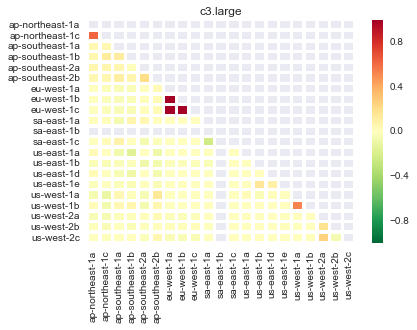

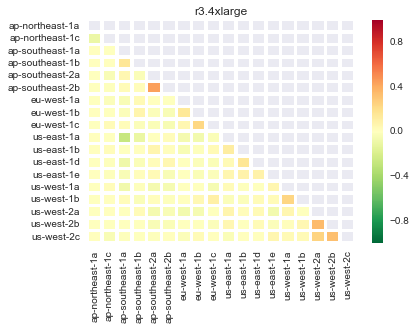

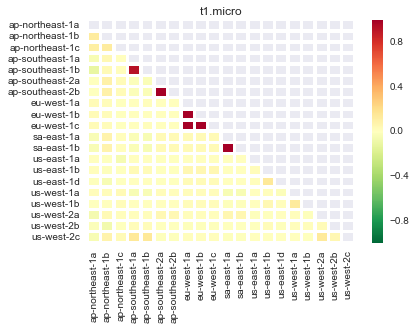

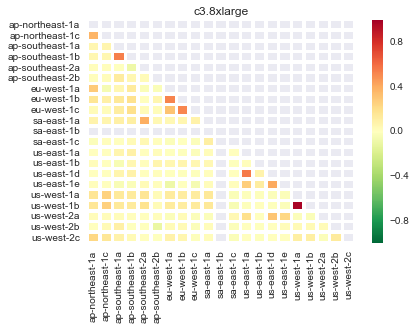

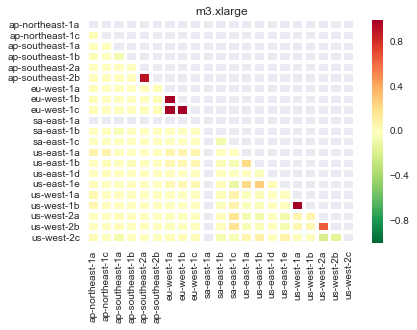

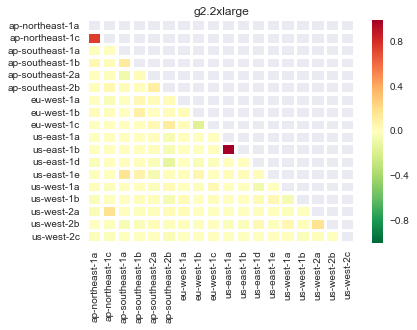

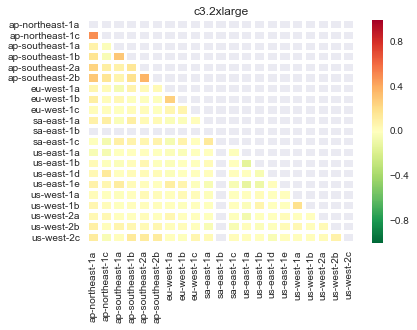

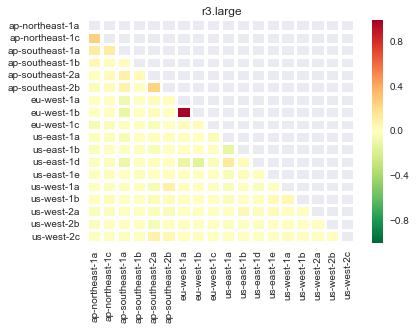

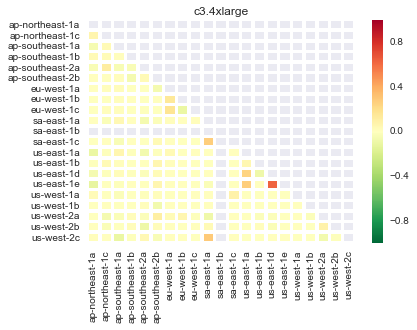

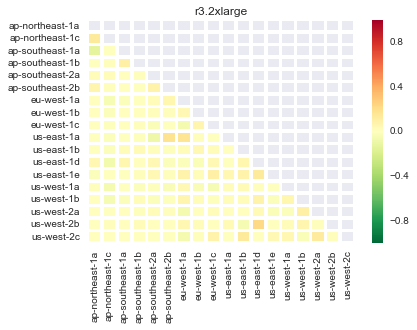

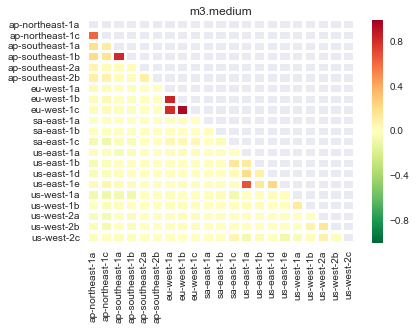

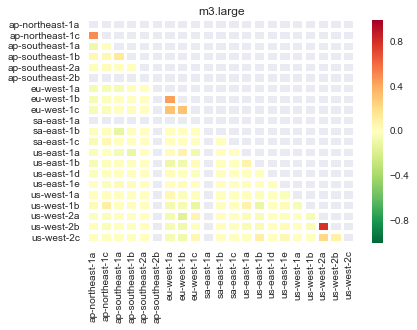

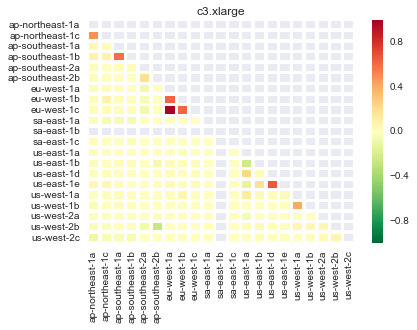

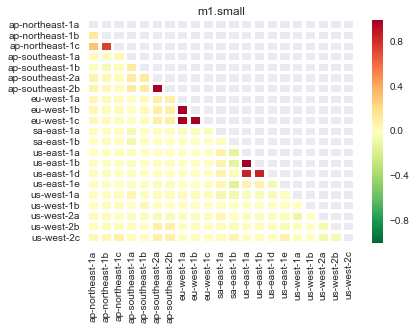

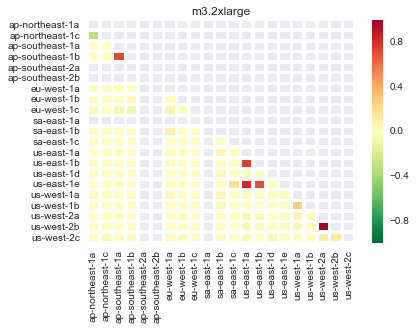

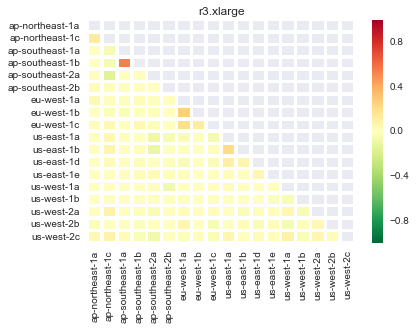

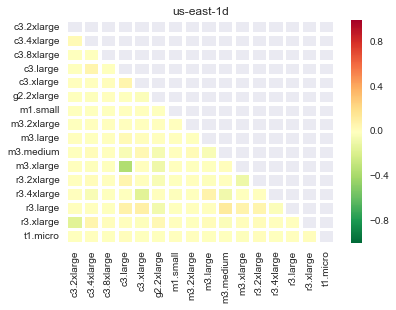

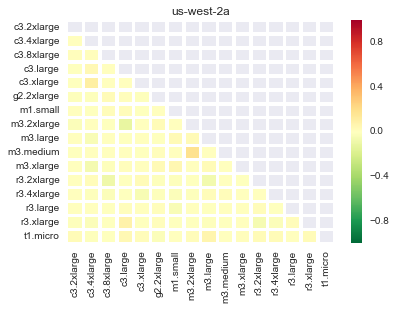

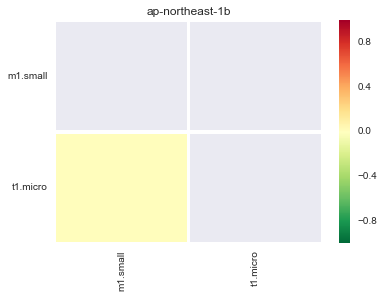

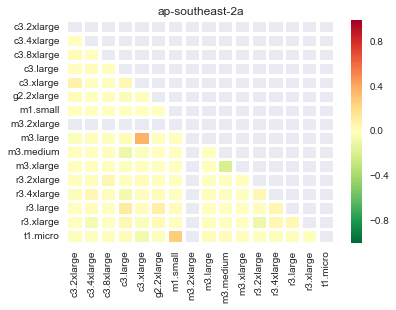

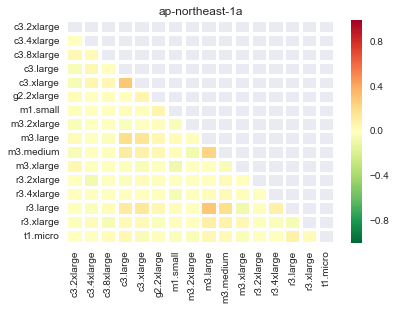

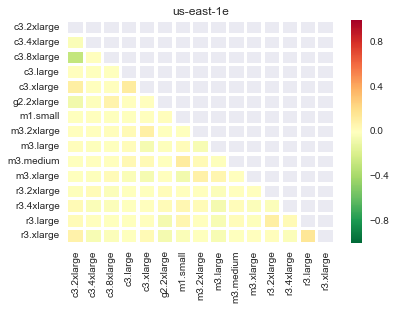

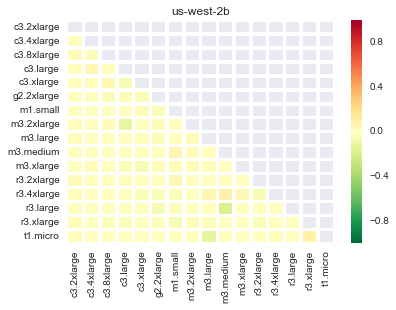

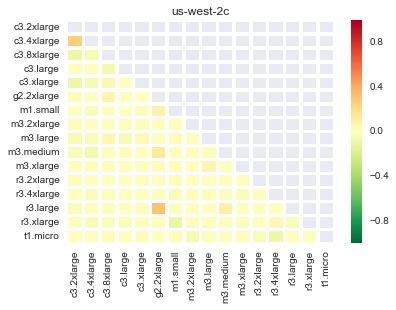

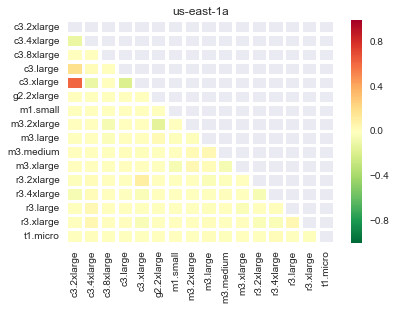

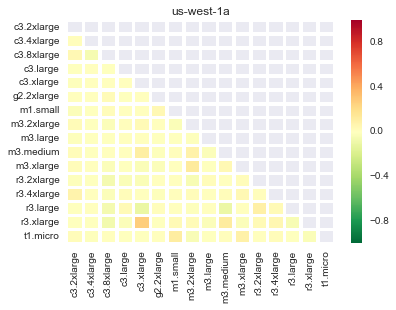

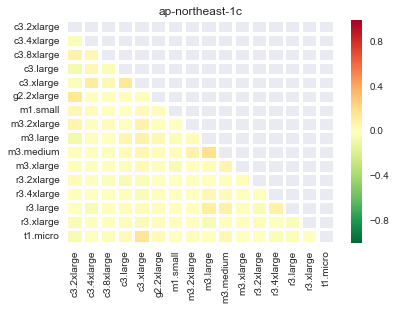

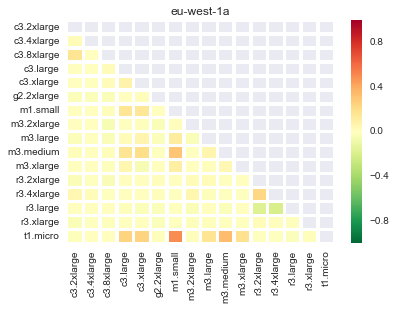

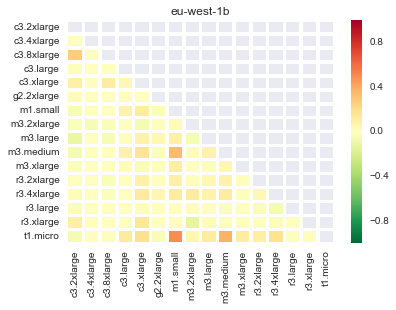

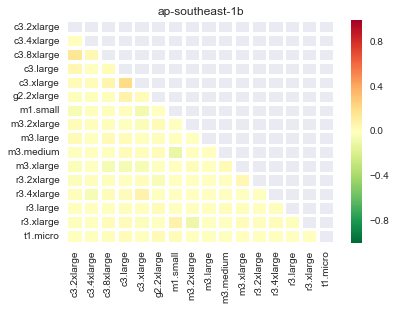

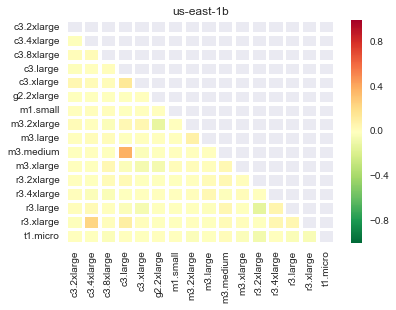

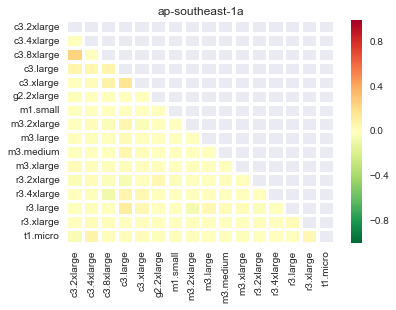

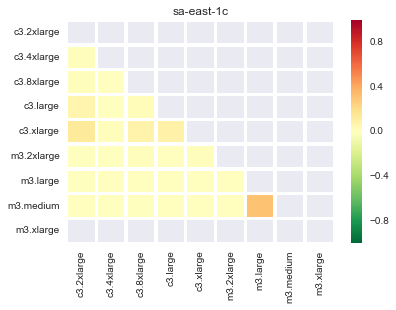

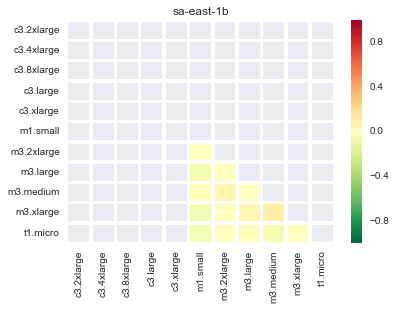

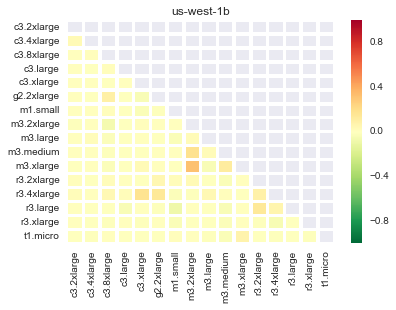

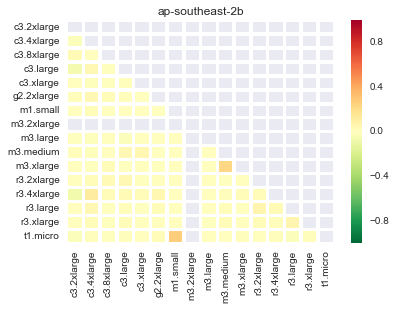

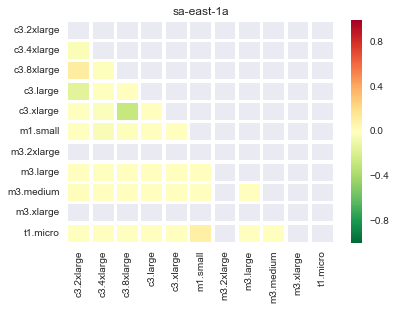

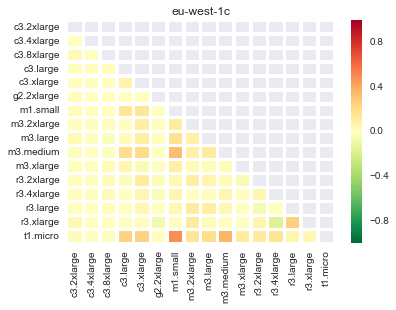

In [221]:
for key in typedfs:
    typedfs[key].index = typedfs[key].TimeStamp
    typedfs[key]       = typedfs[key].drop(['TimeStamp'],axis=1)
    #Normalize data
        #typedfs[key] = typedfs[key].apply(lambda row: np.log(row).diff(), axis=0 )
    typedfs[key] = typedfs[key].diff(axis=0)
    corrGraph(key, typedfs[key])
    
for key in zonedfs:
    zonedfs[key].index = zonedfs[key].TimeStamp
    zonedfs[key]       = zonedfs[key].drop(['TimeStamp'],axis=1)
    #Normalize data
        #zonedfs[key] = zonedfs[key].apply(lambda row: np.log(row).diff(), axis=0 )
    zonedfs[key] = zonedfs[key].diff(axis=0)
    corrGraph(key, zonedfs[key])

In [222]:
#  The reason for some grey rows, 
#  is because those values are all zero meaning
#  the price did not change ever for that time series.

print(typedfs['c3.large']['sa-east-1b'].head(20))

TimeStamp
2015-02-11 02:00:00    NaN
2015-02-11 03:00:00    0.0
2015-02-11 04:00:00    0.0
2015-02-11 05:00:00    0.0
2015-02-11 06:00:00    0.0
2015-02-11 07:00:00    0.0
2015-02-11 08:00:00    0.0
2015-02-11 09:00:00    0.0
2015-02-11 10:00:00    0.0
2015-02-11 11:00:00    0.0
2015-02-11 12:00:00    0.0
2015-02-11 13:00:00    0.0
2015-02-11 14:00:00    0.0
2015-02-11 15:00:00    0.0
2015-02-11 16:00:00    0.0
2015-02-11 17:00:00    0.0
2015-02-11 18:00:00    0.0
2015-02-11 19:00:00    0.0
2015-02-11 20:00:00    0.0
2015-02-11 21:00:00    0.0
Name: sa-east-1b, dtype: float64


### Reference:

[pattern matching over time series data](http://stats.stackexchange.com/questions/136091/sequential-pattern-matching-in-time-series-data)